In [1]:
import pathlib

In [2]:
import numpy as np

In [3]:
from fastai.vision import (
    ImageList, 
    cnn_learner, # function to create a new convolutional neural network learner
    models, # models that the cnn_learner knows about (model architectures and their corresponding weights)
    error_rate,
    get_transforms, 
    imagenet_stats, 
    ClassificationInterpretation # for data analyzation after training
)

In [4]:
chrono_images_path = pathlib.Path('/notebooks/WatchProj/data')

In [5]:
np.random.seed(42) # preserves state of randomness

In [6]:
# Data Preprocessing Pipeline
data = ( 
    ImageList.from_folder(chrono_images_path)
    .split_by_rand_pct()
    .label_from_re(r'.*\/(.+)-.+-.+.jpg')
    .transform(get_transforms())
    .databunch()
    .normalize(imagenet_stats)
)

# Data Preprocessing Pipeline Functions
### >> Order is Important <<
### 1. `ImageList.from_folder()` 
- converts a folder of images into a list of images (all images must be same resolution)
- necessary first step in preprocessing an image dataset

### 2. `.split_by_rand_pct()` 
- randomly partitions the images into a training dataset and a validation dataset
- model's performance on validation dataset gives insight to model's ability to generalize on new, unseen data while actively training the model

### 3. `.label_from_re()` 
- tells fastai library how data is labeled
- as defined in cell 4, fastai knows where the data is (the path), but it does not know how the data is labeled
- in this case, the labels are in the filename
- go to https://rubular.com/ and 20:00 of https://www.youtube.com/watch?v=dC4pdJyAaOg&t=478s for tutorial
- for example, the images are labeled like `gucci-188-987.jpg`
- the goal is to write a regular expression for just the brand name: in this case, `gucci`

### 4. `.transform(get_transforms())`
- augments data with `get_transforms` (standard set of transformations) | (slightly rotate, mirror, flip, etc.)
- for example, given an image and a slightly rotated copy of said image: the pixel values will be very different, however, the model should still classify both images the same
- data augmentation can greatly increase the number of images in a dataset, which can greatly improve the model

### 5. `.databunch()` 
- creates necessary `ImageDataBunch` object that must be passed into fastai model
- the above preprocessing functions are necessary precedents to creating the `ImageDataBunch` correctly

### 6. `.normalize(imagenet_stats)` 
- normalizes data to pass into model (converts to value in range of 0-1)
- data normalization helps model train and generalize better (neural networks like when all values are between 0-1)
- ImageNet (`imagenet_stats`) is a public dataset of 100,000s of images, classified into 1000s of categories, trained for 100s of hours
- in data science, it is common to borrow normalization parameters that have been trained on massive datasets (much better than random normalization) 

In [7]:
data

ImageDataBunch;

Train: LabelList (3135 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: CategoryList
zenith,zenith,zenith,zenith,zenith
Path: /notebooks/WatchProj/data;

Valid: LabelList (783 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: CategoryList
movado,breitling,patekphilippe,gucci,jaegerlecoultre
Path: /notebooks/WatchProj/data;

Test: None

# More Information
### Data
- each image is RGB (3 color channels) and 210 x 210 pixels (3, 210, 210) 
- each pixel in each image is an RGB value ranging from 0-255 (originally), however normalized to a value between 0-1
- each image is an array of items (the items being the pixel values)
- the resulting function will take in the arrays of pixel values and return an array of predictions 
- the predictions will be an array of 13 values (13 watch brands) adding up to 1.0 on how confident the model is that each image's pixel values represent each brand

### Neural Networks
- weights (parameters) are the actual values of each individual node
- pass images to node --> pass through activation function --> pass to next neuron
- while training, observe loss of entire system: given entire training dataset and the predicted outcomes, how wrong is the system
- go back and update the weights of the nodes that are most responsible for being wrong until loss is minimized (backpropagation)

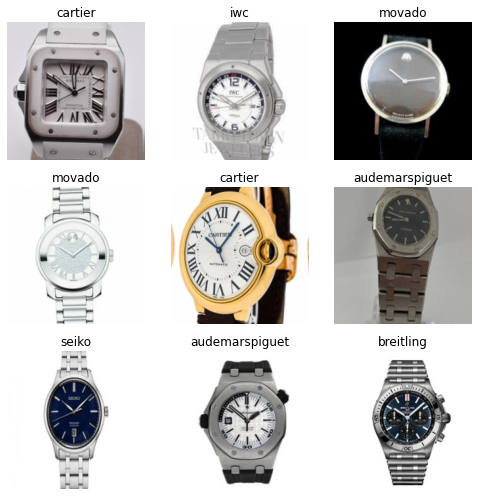

In [13]:
data.show_batch(rows=3, figsize=(7,7)) # random batch from data

In [11]:
data.classes

['audemarspiguet',
 'breitling',
 'cartier',
 'gucci',
 'iwc',
 'jaegerlecoultre',
 'movado',
 'omega',
 'panerai',
 'patekphilippe',
 'rolex',
 'seiko',
 'zenith']

# Model Selection
- instead of constructing the model architecture from scratch and using randomized weights, it is efficient to simply borrow the architecture and weights from a trained model
- `model.resnet34` has been trained on the ImageNet dataset and proven successful, so using its architecture and weights is a good idea
- training on this dataset will make it slightly more optimized to classify watches of different brands

In [19]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate) # downloads .pth file, which consists of the pretrained weights

In [20]:
learner

Learner(data=ImageDataBunch;

Train: LabelList (3135 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: CategoryList
zenith,zenith,zenith,zenith,zenith
Path: /notebooks/WatchProj/data;

Valid: LabelList (783 items)
x: ImageList
Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210),Image (3, 210, 210)
y: CategoryList
movado,breitling,patekphilippe,gucci,jaegerlecoultre
Path: /notebooks/WatchProj/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNo

In [21]:
type(learner)

fastai.basic_train.Learner

# Training
- `fit_one_cycle(5)` modulates between different learning rates
- updating weights at fixed velocity during backpropagation is the learning rate

In [22]:
learner.fit_one_cycle(5) # training the model | takes around a minute on GPU cloud instance

epoch,train_loss,valid_loss,error_rate,time
0,3.014441,1.729179,0.499361,00:15
1,2.210871,1.534662,0.444444,00:14
2,1.742363,1.373572,0.415070,00:14
3,1.405022,1.286092,0.380587,00:14
4,1.182757,1.264194,0.372925,00:14


- error rate got down to 37%, meaning the model was classifying (and can currently classify) images from the validation set with 63% accuracy

# Data Analyzation

In [23]:
interpretation = ClassificationInterpretation.from_learner(learner)

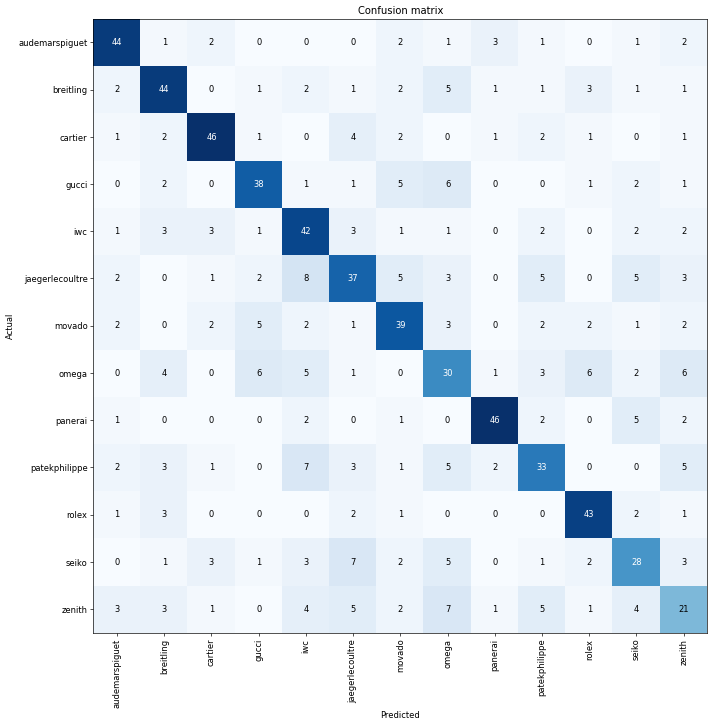

In [24]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60) # confusion matrix

- confusion matrices are good for determining if a model is working correctly
- for example, it makes sense that the model is missclassifed Gucci and Movado as both are fashion brands (the watches look similar)

In [25]:
interpretation.most_confused(min_val=2)

[('jaegerlecoultre', 'iwc', 8),
 ('patekphilippe', 'iwc', 7),
 ('seiko', 'jaegerlecoultre', 7),
 ('zenith', 'omega', 7),
 ('gucci', 'omega', 6),
 ('omega', 'gucci', 6),
 ('omega', 'rolex', 6),
 ('omega', 'zenith', 6),
 ('breitling', 'omega', 5),
 ('gucci', 'movado', 5),
 ('jaegerlecoultre', 'movado', 5),
 ('jaegerlecoultre', 'patekphilippe', 5),
 ('jaegerlecoultre', 'seiko', 5),
 ('movado', 'gucci', 5),
 ('omega', 'iwc', 5),
 ('panerai', 'seiko', 5),
 ('patekphilippe', 'omega', 5),
 ('patekphilippe', 'zenith', 5),
 ('seiko', 'omega', 5),
 ('zenith', 'jaegerlecoultre', 5),
 ('zenith', 'patekphilippe', 5),
 ('cartier', 'jaegerlecoultre', 4),
 ('omega', 'breitling', 4),
 ('zenith', 'iwc', 4),
 ('zenith', 'seiko', 4),
 ('audemarspiguet', 'panerai', 3),
 ('breitling', 'rolex', 3),
 ('iwc', 'breitling', 3),
 ('iwc', 'cartier', 3),
 ('iwc', 'jaegerlecoultre', 3),
 ('jaegerlecoultre', 'omega', 3),
 ('jaegerlecoultre', 'zenith', 3),
 ('movado', 'omega', 3),
 ('omega', 'patekphilippe', 3),
 ('pa

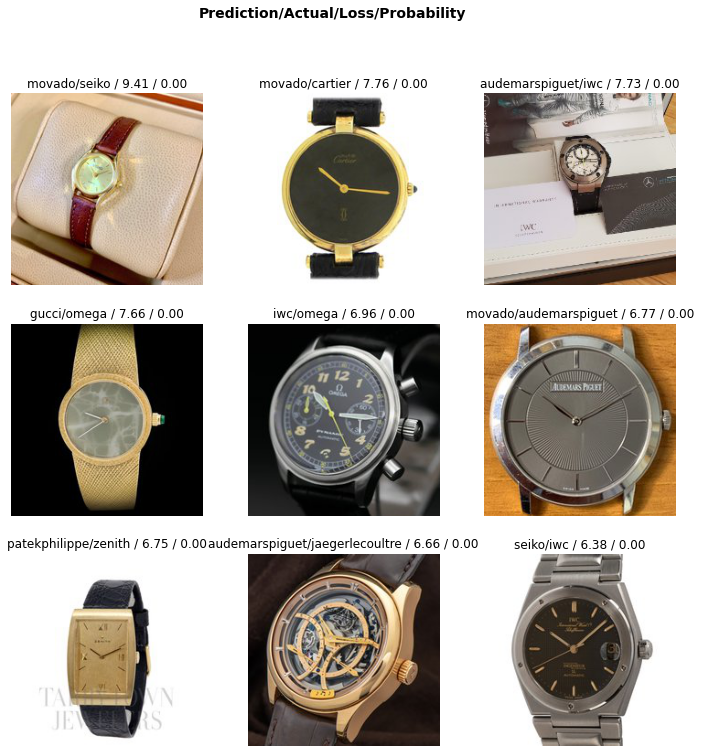

In [26]:
interpretation.plot_top_losses(9, figsize=(12,12))

- in the first example, the model was 94% confident the watch was a Movado, however it was actually a Seiko

# Making Predictions

In [27]:
data.valid_ds[108] # image in validation dataset

(Image (3, 210, 210), Category iwc)

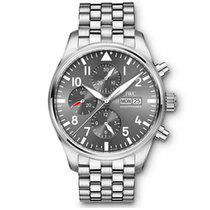

In [28]:
data.valid_ds[108][0] # watch itself

In [29]:
data.valid_ds[108][1] # brand label

Category iwc

In [30]:
learner.predict(data.valid_ds[108][0])

(Category iwc,
 tensor(4),
 tensor([1.9055e-03, 3.9016e-02, 4.4175e-04, 5.1968e-03, 8.9869e-01, 4.7531e-03,
         8.8049e-05, 3.5664e-02, 1.5291e-05, 5.5386e-04, 5.8749e-04, 5.7119e-03,
         7.3749e-03]))

- given a random image from the validation dataset, the model was able to correctly classify the watch as an IWC
- `tensor(4)` being `8.9869e-01` (the most confident prediction), meaning the model was roughly 89% confident the watch was an IWC

# Saving the Weights

In [31]:
learner.save('stage-1') # arbitary file name

- creates "models" folder in "data" folder
- saves .pth file of this model's trained weights to "models" folder

# Fine-Tuning the Model
- input layers = bottom layers | general pattern recognition
- output layers = top layers | distinct features
- during the first stage of training, only the top layers were trained, while the bottom layers were not as they are more general
- after training the top layers of a pretrained model, it can be a good idea to go back and train the bottom layers as well (fine-tuning)

In [32]:
learner.lr_find() # finding appropriate learning rate for fine-tuning (training bottom layers) model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


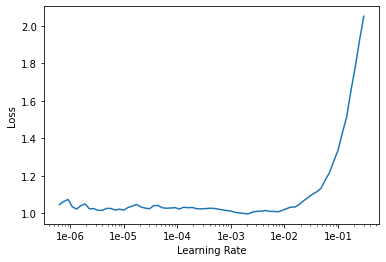

In [33]:
learner.recorder.plot() # expected loss at various learning rates

In [35]:
learner.unfreeze() # opens up bottom layers to training (weights of bottom layers now susceptible to adjustment) 

- when using pretrained models, bottom layers are automatically frozen upon import

In [36]:
learner.fit_one_cycle(5, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.377394,4.096896,0.642401,00:18
1,1.487416,1.810512,0.485313,00:18
2,1.248775,1.453098,0.401022,00:18
3,0.900044,1.010545,0.280971,00:18
4,0.584138,0.854674,0.254151,00:18


- achieved a new accuracy of around 75%

# Making Predictions

In [41]:
data.valid_ds[70] # image in validation dataset

(Image (3, 210, 210), Category zenith)

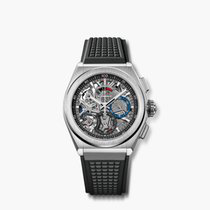

In [42]:
data.valid_ds[70][0] # watch itself

In [43]:
data.valid_ds[70][1] # brand label

Category zenith

In [44]:
learner.predict(data.valid_ds[70][0])

(Category zenith,
 tensor(12),
 tensor([4.9810e-02, 2.7824e-02, 2.7298e-04, 7.6071e-04, 6.5141e-02, 9.1525e-03,
         9.9399e-04, 6.0704e-04, 3.5142e-04, 2.6199e-02, 1.9143e-04, 4.2428e-05,
         8.1865e-01]))

# Final Saves

In [45]:
learner.save('stage-2')

In [46]:
learner.export('classifier.pkl')